# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from train import train
from maddpg import Maddpg

%matplotlib inline

# create a new Unity environment
# it needs to be done once, outside any loop, as closing an environment then restarting causes
# a Unity exception about the handle no longer being active.
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", seed=0, 
                       no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]                       
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [2]:
import numpy as np

class RandomSampler():
    
    def __init__(self, vars):
        """Accepts definition of the set of variables to be sampled.
            
            Params:
                vars (list of lists): each item is a list containing:
                                        item 0 - either 'discrete', 'continuous-int' or 'continuous-float'
                                        items 1-N depend on the value of item 0:
                                        if discrete, then these are the set of values to be chosen from
                                        if continuous then these are the min & max bounds of the range
        """
        
        self.vars = vars
        
        self.rng = np.random.default_rng()
    
    
    def sample(self):
        """Draws a random sample of all variables at its disposal.
        
            Returns a list of values in the order of definition.
        """

        rtn = []
        for v in self.vars:
            if v[0] == "discrete":
                choice = self.rng.integers(low=1, high=len(v), size=1)[0]
                rtn.append(v[choice])
                
            elif v[0] == "continuous-int":
                choice = self.rng.integers(low=v[1], high=v[2], size=1)[0]
                rtn.append(choice)
                
            elif v[0] == "continuous-float":
                choice = self.rng.random() * (v[2]-v[1]) + v[1]
                rtn.append(choice)
            
            else:
                print("///// RandomSampler error:  unknown type ", v[0])
            
        return rtn
                
vars = [["discrete", 88, 66, 11, 22, 33, 44, 99, 101, 77],
        ["discrete", 500], #1-item list
        ["continuous-int", 43, 44], #1-item range
        ["continuous-int", 0, 10],
        ["continuous-float", 0.0, 1.0],
        ["continuous-float", -3.3, 0.0],
        ["continuous-float", -1.0, 6.4],
       ]
rs = RandomSampler(vars)

for i in range(3):
    out = rs.sample()
    print("\n", i, "\n", out)



 0 
 [33, 500, 43, 5, 0.2598717058487652, -2.3454868918711886, 3.5184829835062894]

 1 
 [99, 500, 43, 2, 0.8563311885302906, -2.2316783224483547, 0.10949785559103575]

 2 
 [11, 500, 43, 5, 0.9073373851098874, -0.357146125733685, 4.194274747062095]


Ready to train TEST over 1 training sets for 101 episodes each, with fixed params:
    Max episodes  =  101
    Weight decay  =  0.0
    Gamma         =  0.99

///// Beginning training set  TEST.00  with:
      Batch size       = 256
      Buffer size      = 100000
      Bad step prob    = 0.2695
      Noise decay      = 0.999960
      Noise scale      = 0.048
      LR actor         = 0.000010
      LR critic        = 0.000016
      Learning every      30  time steps
      Learn iterations =  3
      Tau              = 0.00164
      Seed             =  44939
100	Running avg/max: 0.008/0.100,  mem:    687/     6 ( 0.9%), avg 820.3 eps/min   
Avg/max time steps/episode = 17.2/36


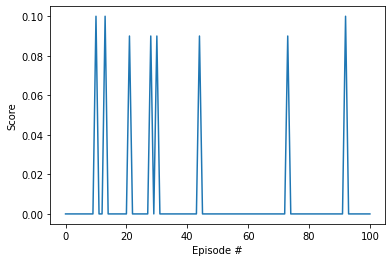



DONE!


In [3]:
# This cell will explore several combinations of hyperparams by training all of them
# Use a random search for the hyperparams

EXPLORE = True

TIME_STEPS         = 400
SAVE_ANALYSIS      = False
MODEL_DISPLAY_STEP = 0 #200k is approx 10k episodes at bad_step_prob = 0.01

if EXPLORE:
    
    # fixed for the session:
    RUN_PREFIX     = "M31"
    EPISODES       = 15001
    NUM_RUNS       = 30
    WEIGHT_DECAY   = 0.0 #was 1.0e-5
    GAMMA          = 0.99
    SEED           = 44939 #(0, 111, 468, 5555, 23100, 44939)
    
    # session variables:
    vars = [["continuous-float", 0.12,     0.50],     #BAD_STEP_PROB
            ["continuous-float", 0.999900, 0.999990], #NOISE_DECAY
            ["continuous-float", 0.010,    0.05],     #NOISE_SCALE
            ["continuous-float", 0.000001, 0.000050], #LR_ACTOR
            ["continuous-float", 0.000001, 0.000045], #LR_CRITIC
            ["continuous-int",   20,       101],      #LEARN_EVERY
            ["continuous-int",   1,        4],        #LEARN_ITER
            ["continuous-float", 0.00050,  0.00300],  #TAU
            ["discrete",         128, 256, 512, 1000] #BATCH
           ]
    rs = RandomSampler(vars)
    
    print("Ready to train {} over {} training sets for {} episodes each, with fixed params:"
          .format(RUN_PREFIX, NUM_RUNS, EPISODES))
    print("    Max episodes  = ", EPISODES)
    print("    Weight decay  = ", WEIGHT_DECAY)
    print("    Gamma         = ", GAMMA)
            
    for set_id in range(NUM_RUNS):
        
        # sample the variables
        v = rs.sample()
        BAD_STEP_PROB = v[0]
        NOISE_DECAY   = v[1]
        NOISE_SCALE   = v[2]
        LR_ACTOR      = v[3]
        LR_CRITIC     = v[4]
        LEARN_EVERY   = v[5]
        LEARN_ITER    = v[6]
        TAU           = v[7]
        BATCH         = v[8]

        # set the replay buffer size to that it fills after ~5000 bad episodes
        # (at ~14 experiences/episode), based on the bad step retention rate
        #buffer_size = int(60000 - 50000*(1.0 - BAD_STEP_PROB))
        buffer_size = 100000

        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
        print("\n///// Beginning training set ", RUN_NAME, " with:")
        print("      Batch size       = {:d}".format(BATCH))
        print("      Buffer size      = {:d}".format(buffer_size))
        print("      Bad step prob    = {:.4f}".format(BAD_STEP_PROB))
        print("      Noise decay      = {:.6f}".format(NOISE_DECAY))
        print("      Noise scale      = {:.3f}".format(NOISE_SCALE))
        print("      LR actor         = {:.6f}".format(LR_ACTOR))
        print("      LR critic        = {:.6f}".format(LR_CRITIC))
        print("      Learning every     ", LEARN_EVERY, " time steps")
        print("      Learn iterations = ", LEARN_ITER)
        print("      Tau              = {:.5f}".format(TAU))
        print("      Seed             = ", SEED)

        ##### instantiate the agents and perform the training

        maddpg = Maddpg(state_size, action_size, 2, bad_step_prob=BAD_STEP_PROB,
                        random_seed=SEED, batch_size=BATCH, buffer_size=buffer_size,
                        noise_decay=NOISE_DECAY, learn_every=LEARN_EVERY, 
                        learn_iter=LEARN_ITER, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC,
                        weight_decay=WEIGHT_DECAY, gamma=GAMMA, noise_scale=NOISE_SCALE,
                        tau=TAU, model_display_step=MODEL_DISPLAY_STEP)

        scores = train(maddpg, env, run_name=RUN_NAME, max_episodes=EPISODES, 
                       winning_score=0.5, max_time_steps=TIME_STEPS,
                       checkpoint_interval=2000)

        ##### plot the training reward history

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()

        ##### store the action/noise data, if being used

        if SAVE_ANALYSIS:
            maddpg.save_anal_data(RUN_PREFIX)

                            
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

In [4]:
# load a pre-trained (or partially trained) model and run it in inference mode to watch it perform

#m = Maddpg(24, 2, 2)
#check = m.restore_checkpoint("checkpoint/", "TEST.00", 20)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
"""
for i in range(10):                                        # play game for several episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations             3     # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    num_steps = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        num_steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))
"""

"\nfor i in range(10):                                        # play game for several episodes\n    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \n    states = env_info.vector_observations             3     # get the current state (for each agent)\n    scores = np.zeros(num_agents)                          # initialize the score (for each agent)\n    num_steps = 0\n    while True:\n        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n        env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n        next_states = env_info.vector_observations         # get next state (for each agent)\n        rewards = env_info.rewards                         # get reward (for each agent)\n        dones = env_info.local_done                        # see if episode finished\n        scores += env_i

When finished, you can close the environment.

In [6]:
env.close()